In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = 'C:/Users/psais/Downloads/New folder (7)/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

torch.Size([250, 250, 3])


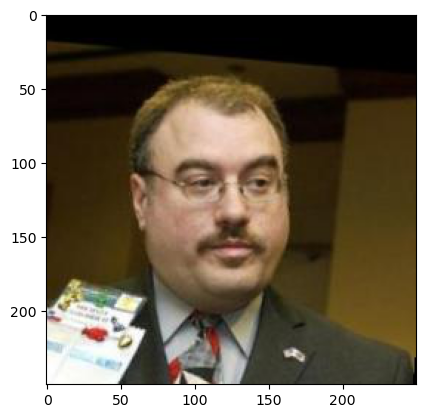

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

1. **Applications:**
   - **AutoEncoders:**
     - Primarily employed for tasks like dimensionality reduction, feature extraction, and learning compact data representations. It is commonly utilized in scenarios such as denoising, where the AutoEncoder (AE) learns to filter out noise from input data.
   - Used in data compression, where the AE learns a compressed version of the input data.

   - **Variational AutoEncoders (VAEs):**
     - Widely used in generative modeling, demonstrating proficiency in generating new data points resembling the input data distribution. Particularly useful in applications like image generation.
     - Applied in semi-supervised learning, leveraging the generative nature of VAEs to enhance datasets.

2. **Architecture:**
   - **AutoEncoders:**
     - Comprises an encoder and a decoder. The encoder compresses input data, producing a latent-space representation. The decoder then reconstructs the original input from this latent representation.

   - **Variational AutoEncoders (VAEs):**
     - Features both an encoder and a decoder, but introduces a distinct latent space representation. The VAE's encoder outputs two values for each input: a mean and a variance (or log-variance). These parameters define a distribution from which a latent space vector is sampled, introducing a crucial element of randomness for generative capabilities.

3. **Loss Function:**
   - **AutoEncoders:**
     - Typically incorporates a reconstruction loss in the loss function, quantifying the fidelity of the decoder's output to the original input. Common choices for this loss include Mean Squared Error (MSE) or Binary Cross-Entropy (BCE), depending on the data nature.

   - **Variational AutoEncoders (VAEs):**
     - Utilizes a loss function that combines both reconstruction loss and a regularization term. The reconstruction loss remains consistent with AEs, ensuring fidelity between decoded samples and the original inputs.
     - Introduces a regularization term, often the Kullback-Leibler (KL) divergence. This term measures the deviation of the learned distribution (defined by encoder's mean and variance) from a prior distribution, typically a standard normal distribution. The regularization encourages the model to learn efficient and robust data representations.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        # Encoder
        self.encoder_fc1 = nn.Linear(3 * 250 * 250, 512)  # Adjust input dimensions as needed
        self.encoder_fc21 = nn.Linear(512, 20)  # Mean of the latent space
        self.encoder_fc22 = nn.Linear(512, 20)  # Log variance of the latent space
        # Decoder
        self.decoder_fc3 = nn.Linear(20, 512)
        self.decoder_fc4 = nn.Linear(512, 250 * 250 * 3)  # Adjust output dimensions as needed

    def encode(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        # Encoder forward pass
        encoder_h1 = F.relu(self.encoder_fc1(x))
        return self.encoder_fc21(encoder_h1), self.encoder_fc22(encoder_h1)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick for sampling from a normal distribution
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # Decoder forward pass
        decoder_h3 = F.relu(self.decoder_fc3(z))
        return torch.sigmoid(self.decoder_fc4(decoder_h3))

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        # Encoder, reparameterization, and decoder forward passes
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

1. **Reparameterization Trick:**
   - **Role of Reparameterization:**
     - In VAEs, the reparameterization trick is pivotal for enhancing the model's performance in generative tasks. Unlike traditional autoencoders that output a fixed vector in the latent space, VAEs output a distribution, defined by mean (mu) and variance (logvar), from which a latent vector is sampled. This introduction of randomness through sampling is crucial for the generative capabilities of the model.

   - **Implementation Detail:**
     - `std = torch.exp(0.5 * logvar)`: Computes the standard deviation from the log variance, using log variance for numerical stability.
     - `eps = torch.randn_like(std)`: Generates a tensor of random values from a standard normal distribution, matching the shape of the standard deviation.
     - `return mu + eps * std`: The reparameterization trick itself, where sampling occurs from a standard normal distribution (eps), and this sample is scaled and shifted by the standard deviation (std) and mean (mu). This trick enables backpropagation through the random sampling process by treating eps as an input noise vector.

2. **The Decoder and Its Role in Generation:**
   - **Process:**
     - The decoder in your VAE, defined within the decode function, is tasked with generating data points from latent space representations. The latent vector (z), sampled using the reparameterization trick, undergoes the first fully connected layer (self.fc3) with a subsequent ReLU activation. The output is then processed through another fully connected layer (self.fc4). The final output is obtained by applying a sigmoid function, a common choice in generative tasks, especially when data points (e.g., pixels in an image) are normalized between 0 and 1.

   - **Significance in VAEs:**
     - The decoder is crucial for mapping latent space vectors back to the data space. In a well-trained VAE, latent vectors, whether encoding real data or sampled from the latent space distribution, should be decoded into realistic and plausible data points. Specifically in image generation, the decoder learns to reconstruct images from latent representations, aiming to resemble the distribution of the original dataset.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [8]:
# Instantiate the VAE model and move it to the specified device (GPU or CPU)
model = VariationalAutoencoder().to(device)

# Create an iterator for the dataloader
dataiter = iter(dataloader)

# Load a batch of images and move them to the specified device
images, _ = next(dataiter)
images = images.to(device)

# Make sure the model is in evaluation mode (no gradient computation)
model.eval()

# Process a single image from the batch
image = images[0].unsqueeze(0)

# Forward pass through the model
with torch.no_grad():
    # Get the reconstructed image, mean (mu), and log variance (logvar) from the model
    reconstructed, mu, logvar = model(image)

    # Print the shapes of the encoder's output (mu and logvar)
    print("Shape of the encoder's output (mu):", mu.shape)
    print("Shape of the encoder's output (logvar):", logvar.shape)

    # Generate new samples in the latent space using the reparameterization trick
    samples = model.reparameterize(mu, logvar)
    print("Shape of the samples in the latent space:", samples.shape)

    # Decode the generated samples to obtain new images
    generated_images = model.decode(samples)
    print("Shape of the decoder's output (generated images):", generated_images.shape)

Shape of the encoder's output (mu): torch.Size([1, 20])
Shape of the encoder's output (logvar): torch.Size([1, 20])
Shape of the samples in the latent space: torch.Size([1, 20])
Shape of the decoder's output (generated images): torch.Size([1, 187500])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [9]:
# Calculate the total number of trainable parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the total number of parameters
print("Total number of parameters in the model:", total_params)

Total number of parameters in the model: 192219284


In [10]:
# Reshape the output from the decoder to match the input image dimensions
# Assuming the input images are of shape [batch_size, channels, height, width]
reconstructed = generated_images.view(-1, 3, 250, 250)

# Calculate the reconstruction loss using binary cross-entropy
reconstruction_loss = F.binary_cross_entropy(reconstructed, image, reduction='sum')

# Calculate the KL divergence loss
kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Total VAE loss as the sum of reconstruction loss and KL divergence loss
vae_loss = reconstruction_loss + kl_divergence_loss

# Instantiate an Adam optimizer for model parameters with a specified learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Print the optimizer details
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


1. **Reconstruction Loss:**
   - **Purpose:** Measures how well the generated (reconstructed) images match the original input images.
   - **Term in Loss Function:** `reconstruction_loss = F.binary_cross_entropy(reconstructed, image, reduction='sum')`
   - **Explanation:** The reconstruction loss compares each pixel in the generated image (`reconstructed`) with the corresponding pixel in the original input image (`image`). Binary cross-entropy is often used for comparing pixel-wise similarity. The goal is to minimize this loss, encouraging the model to generate images that closely resemble the original input.

2. **KL Divergence Loss:**
   - **Purpose:** Regularizes the latent space by penalizing deviations of the learned distribution from a standard normal distribution.
   - **Term in Loss Function:** `kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())`
   - **Explanation:** The KL divergence loss penalizes the encoder for deviating from a standard normal distribution. The terms `mu` and `logvar` represent the mean and log variance of the learned distribution, respectively. The goal is to make the learned distribution in the latent space close to a standard normal distribution. This regularization helps ensure that the latent space has a well-defined structure, making it more interpretable and aiding in the generation of diverse and meaningful samples.

3. **Total VAE Loss:**
   - **Purpose:** Combines the reconstruction and KL divergence losses into a single objective function for optimization.
   - **Term in Loss Function:** `vae_loss = reconstruction_loss + kl_divergence_loss`
   - **Explanation:** The total VAE loss is the sum of the reconstruction loss and the KL divergence loss. The model aims to minimize this combined loss during training. The reconstruction loss encourages accurate image reconstruction, while the KL divergence loss enforces regularization in the latent space. Balancing these two components ensures that the VAE learns a latent space representation that facilitates both accurate reconstruction and meaningful interpolation in the latent space.


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [31]:
# Number of epochs
num_epochs = 5  # Adjust this based on your needs

# Move model to the right device
model.to(device)

# Loop through each epoch
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    # Loop through each batch in the dataloader
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device) 
        reconstructed, mu, logvar = model(images)
        reconstructed = reconstructed.view(images.size())
        reconstruction_loss = F.binary_cross_entropy(reconstructed, images, reduction='sum')
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_divergence_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 
        percentage_done = 100. * (batch_idx + 1) / len(dataloader)
        print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, {percentage_done:.2f}% complete, Batch Loss: {loss.item() / images.size(0):.4f}')

    avg_loss = running_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}')


Epoch 1/5, Batch 1/414, 0.24% complete, Batch Loss: 122620.2109
Epoch 1/5, Batch 2/414, 0.48% complete, Batch Loss: 130688.5234
Epoch 1/5, Batch 3/414, 0.72% complete, Batch Loss: 127589.5000
Epoch 1/5, Batch 4/414, 0.97% complete, Batch Loss: 124354.5547
Epoch 1/5, Batch 5/414, 1.21% complete, Batch Loss: 121426.3594
Epoch 1/5, Batch 6/414, 1.45% complete, Batch Loss: 131027.1562
Epoch 1/5, Batch 7/414, 1.69% complete, Batch Loss: 128905.2266
Epoch 1/5, Batch 8/414, 1.93% complete, Batch Loss: 130010.2266
Epoch 1/5, Batch 9/414, 2.17% complete, Batch Loss: 128978.8438
Epoch 1/5, Batch 10/414, 2.42% complete, Batch Loss: 127524.9531
Epoch 1/5, Batch 11/414, 2.66% complete, Batch Loss: 132409.5938
Epoch 1/5, Batch 12/414, 2.90% complete, Batch Loss: 125792.3750
Epoch 1/5, Batch 13/414, 3.14% complete, Batch Loss: 125959.3125
Epoch 1/5, Batch 14/414, 3.38% complete, Batch Loss: 126839.6250
Epoch 1/5, Batch 15/414, 3.62% complete, Batch Loss: 127455.4922
Epoch 1/5, Batch 16/414, 3.86% com

Epoch Iteration:
- The loop iterates for a defined number of epochs, covering the entire dataset.

Training Mode:
- The VAE model is switched to training mode, enabling essential training functionalities like backpropagation and potential dropout (if employed).

Batch Processing:
- Images are processed in batches, enhancing computational efficiency, and each batch is loaded onto the specified computing device, such as a GPU.

Forward Pass:
- Images undergo a forward pass through the VAE model, resulting in the generation of reconstructed images, mean (mu), and log variance (logvar) representing the latent space.

Reshaping Output:
- The reconstructed images are reshaped to align with the input dimensions, ensuring consistency in comparisons and evaluations.

Loss Computation:
- The loss function is applied, encompassing both the reconstruction loss (measuring the dissimilarity between input and output images) and the KL divergence loss (quantifying the deviation between the learned latent distribution and a standard normal distribution).

Backward Pass:
- The computed loss is backpropagated through the model, facilitating the adjustment of model weights to minimize the overall loss.

Optimizer Step:
- The optimizer takes a step, updating the model parameters based on the gradients calculated during the backward pass.

Loss Tracking:
- Running loss is cumulatively tracked throughout the epoch, offering insights into the model's performance and how it adapts to the data.

Average Loss Reporting:
- At the conclusion of each epoch, the average loss is computed and reported, serving as a key metric to gauge the overall training progress and the convergence of the model.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

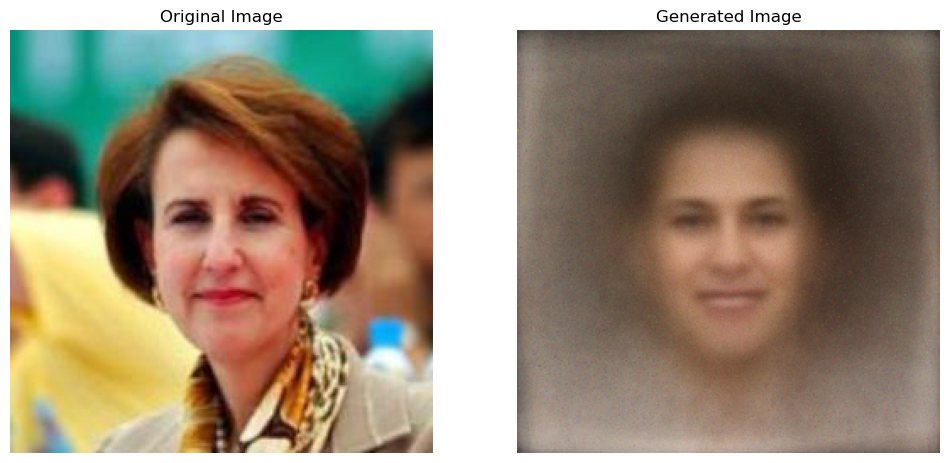

In [38]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images from the dataloader
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select a random image from the batch and move it to the configured device
random_image = images[random.randint(0, images.size(0) - 1)].to(device)

# Plotting the original and generated images
plt.figure(figsize=(12, 6))

# Displaying the original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(random_image.permute(1, 2, 0).cpu().numpy())  # Permute to (height, width, channels) for display
plt.axis('off')

# Generate an image using the VAE
with torch.no_grad():
    # Correctly flattening the image and passing it to the encoder
    flat_image = random_image.view(1, -1).to(device)  # Adding batch dimension and flattening
    mu, logvar = model.encode(flat_image)
    sample = model.reparameterize(mu, logvar)
    generated_image = model.decode(sample)

    # Reshape the generated image to its original dimensions
    generated_image = generated_image.view(3, 250, 250)

# Displaying the generated image
plt.subplot(1, 2, 2)
plt.title("Generated Image")
plt.imshow(generated_image.permute(1, 2, 0).cpu().numpy())  # Permute to (height, width, channels) for display
plt.axis('off')

# Show the plot
plt.show()